## Action 1 针对Delicious数据集，对SimpleTagBased算法进行改进（使用NormTagBased、TagBased-TFIDF算法）

In [3]:
import random
import math
import operator
import pandas as pd

file_path = "./user_taggedbookmarks-timestamps.dat"
# 字典类型，保存了user对item的tag，即{userid: {item1:[tag1, tag2], ...}}
records = {}
# 训练集，测试集
train_data = dict()
test_data = dict()
# 用户标签，商品标签
user_tags = dict()
tag_items = dict()
user_items = dict()
# 增加一些dict
item_tags = dict()
tag_users = dict()
item_users = dict()

In [13]:
# 使用测试集，计算准确率和召回率
def precisionAndRecall(N):
    hit = 0
    h_recall = 0
    h_precision = 0
    for user,items in test_data.items():
        if user not in train_data:
            continue
        # 获取Top-N推荐列表
        rank = recommend(user, N)
        for item,rui in rank:
            if item in items:
                hit = hit + 1
        h_recall = h_recall + len(items)
        h_precision = h_precision + N
    #print('一共命中 %d 个, 一共推荐 %d 个, 用户设置tag总数 %d 个' %(hit, h_precision, h_recall))
    # 返回准确率 和 召回率
    return (hit/(h_precision*1.0)), (hit/(h_recall*1.0))

# 对用户user推荐Top-N
def recommend(user, N):
    recommend_items=dict()
    # 对Item进行打分，分数为所有的（用户对某标签使用的次数 wut, 乘以 商品被打上相同标签的次数 wti）之和
    tagged_items = user_items[user]     
    for tag, wut in user_tags[user].items():
        #print(self.user_tags[user].items())
        for item, wti in tag_items[tag].items():
            if item in tagged_items:
                continue
            # NormTagBased-1 算法
            norm = len(tag_users[tag].items())*len(user_tags[user].items())
            # TagBased-IDF 算法
            norm = math.log(len(tag_users[tag].items()) + 1)
            #print('wut = %s, wti = %s' %(wut, wti))
            if item not in recommend_items:
                recommend_items[item] = wut * wti/norm #SimpleTagBased
            else:
                recommend_items[item] = recommend_items[item] + wut * wti
    return sorted(recommend_items.items(), key=operator.itemgetter(1), reverse=True)[0:N]

# 使用测试集，对推荐结果进行评估
def testRecommend():
    print("推荐结果评估")
    print("%3s %10s %10s" % ('N',"精确率",'召回率'))
    for n in [5,10,20,40,60,80,100]:
        precision,recall = precisionAndRecall(n)
        print("%3d %10.3f%% %10.3f%%" % (n, precision * 100, recall * 100))
        
# 数据加载
def load_data():
    print("开始数据加载...")
    df = pd.read_csv(file_path, sep='\t')
    for i in range(len(df)):
        uid = df['userID'][i]
        iid = df['bookmarkID'][i]
        tag = df['tagID'][i]
        # 键不存在时，设置默认值{}
        records.setdefault(uid,{})
        records[uid].setdefault(iid,[])
        records[uid][iid].append(tag)
    print("数据集大小为 %d." % (len(df)))
    print("设置tag的人数 %d." % (len(records)))
    print("数据加载完成\n")

# 将数据集拆分为训练集和测试集
def train_test_split(ratio, seed=100):
    random.seed(seed)
    for u in records.keys():
        for i in records[u].keys():
            # ratio比例设置为测试集
            if random.random()<ratio:
                test_data.setdefault(u,{})
                test_data[u].setdefault(i,[])
                for t in records[u][i]:
                    test_data[u][i].append(t)
            else:
                train_data.setdefault(u,{})
                train_data[u].setdefault(i,[])
                for t in records[u][i]:
                    train_data[u][i].append(t)        
    print("训练集样本数 %d, 测试集样本数 %d" % (len(train_data),len(test_data)))

# 设置矩阵 mat[index, item] = 1
def addValueToMat(mat, index, item, value=1):
    if index not in mat:
        mat.setdefault(index,{})
        mat[index].setdefault(item,value)
    else:
        if item not in mat[index]:
            mat[index][item] = value
        else:
            mat[index][item] += value


# 使用训练集，初始化user_tags, tag_items, user_items
def initStat():
    records=train_data
    for u,items in records.items():
        for i,tags in items.items():
            for tag in tags:
                #print tag
                # 用户和tag的关系
                addValueToMat(user_tags, u, tag, 1)
                # tag和item的关系
                addValueToMat(tag_items, tag, i, 1)
                # 用户和item的关系
                addValueToMat(user_items, u, i, 1)
                # item和tag的关系
                addValueToMat(item_tags, i, tag, 1)
                # tag和用户的关系
                addValueToMat(tag_users, tag, u, 1)
                # items和用户的关系
                addValueToMat(item_users, i, u, 1)
    print("user_tags, tag_items, user_items初始化完成.")
    print("user_tags大小 %d, tag_items大小 %d, user_items大小 %d" % (len(user_tags), len(tag_items), len(user_items)))

In [14]:
# 数据加载
load_data()
# 训练集，测试集拆分，20%测试集
train_test_split(0.2)
initStat()
testRecommend()

开始数据加载...
数据集大小为 437593.
设置tag的人数 1867.
数据加载完成

训练集样本数 1860, 测试集样本数 1793
user_tags, tag_items, user_items初始化完成.
user_tags大小 1860, tag_items大小 36884, user_items大小 1860
推荐结果评估
  N        精确率        召回率
  5      0.873%      0.374%
 10      0.700%      0.599%
 20      0.518%      0.887%
 40      0.382%      1.309%
 60      0.308%      1.582%
 80      0.270%      1.850%
100      0.244%      2.085%


## Action 2 对Titanic数据进行清洗，使用之前介绍过的10种模型中的至少2种（包括TPOT）

In [27]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.feature_extraction import DictVectorizer

# 数据加载
train_data = pd.read_csv('./train.csv')
test_data = pd.read_csv('./test.csv')
# 数据探索
# 查看train_data信息
#pd.set_option('display.max_columns', None) #显示所有列
print('查看数据信息：列名、非空个数、类型等')
print(train_data.info())
print('-'*30)
print('查看数据摘要')
print(train_data.describe())
print('-'*30)
print('查看离散数据分布')
print(train_data.describe(include=['O']))
print('-'*30)
print('查看前5条数据')
print(train_data.head())
print('-'*30)
print('查看后5条数据')
print(train_data.tail())

查看数据信息：列名、非空个数、类型等
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
------------------------------
查看数据摘要
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642

In [28]:
# 使用平均年龄来填充年龄中的nan值
train_data['Age'].fillna(train_data['Age'].mean(), inplace=True)
test_data['Age'].fillna(test_data['Age'].mean(),inplace=True)
# 使用票价的均值填充票价中的nan值
train_data['Fare'].fillna(train_data['Fare'].mean(), inplace=True)
test_data['Fare'].fillna(test_data['Fare'].mean(),inplace=True)

print(train_data['Embarked'].value_counts())
# 使用登录最多的港口来填充登录港口的nan值
train_data['Embarked'].fillna('S', inplace=True)
test_data['Embarked'].fillna('S',inplace=True)
# 特征选择
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
train_features = train_data[features]
train_labels = train_data['Survived']
test_features = test_data[features]
print('特征值')
print(train_features)

S    644
C    168
Q     77
Name: Embarked, dtype: int64
特征值
     Pclass     Sex        Age  SibSp  Parch     Fare Embarked
0         3    male  22.000000      1      0   7.2500        S
1         1  female  38.000000      1      0  71.2833        C
2         3  female  26.000000      0      0   7.9250        S
3         1  female  35.000000      1      0  53.1000        S
4         3    male  35.000000      0      0   8.0500        S
..      ...     ...        ...    ...    ...      ...      ...
886       2    male  27.000000      0      0  13.0000        S
887       1  female  19.000000      0      0  30.0000        S
888       3  female  29.699118      1      2  23.4500        S
889       1    male  26.000000      0      0  30.0000        C
890       3    male  32.000000      0      0   7.7500        Q

[891 rows x 7 columns]


In [29]:
dvec=DictVectorizer(sparse=False) #DictVectorizer是进行one-hot编码，等价于get_dummies()
train_features=dvec.fit_transform(train_features.to_dict(orient='record'))
print(dvec.feature_names_)
# 构造ID3决策树
clf = DecisionTreeClassifier(criterion='entropy')
# 决策树训练
clf.fit(train_features, train_labels)

test_features=dvec.transform(test_features.to_dict(orient='record'))
# 决策树预测
pred_labels = clf.predict(test_features)

# 得到决策树准确率(基于训练集)
acc_decision_tree = round(clf.score(train_features, train_labels), 6)
print(u'score准确率为 %.4lf' % acc_decision_tree)

# 使用K折交叉验证 统计决策树准确率
print(u'cross_val_score准确率为 %.4lf' % np.mean(cross_val_score(clf, train_features, train_labels, cv=10)))

# 使用LR分类器
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=100, verbose=True, random_state=33, tol=1e-4)
clf.fit(train_features, train_labels)

['Age', 'Embarked=C', 'Embarked=Q', 'Embarked=S', 'Fare', 'Parch', 'Pclass', 'Sex=female', 'Sex=male', 'SibSp']
score准确率为 0.9820
cross_val_score准确率为 0.7734


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/muyu/opt/anaconda3/envs/NLP/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


LogisticRegression(random_state=33, verbose=True)

[ -1.7062013   33.88975295  32.3346551   14.69223597   0.10078942
  -4.21976038 -47.2594461  100.         -19.08335597 -14.10678045]


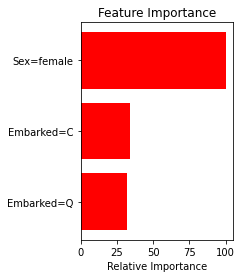

In [31]:
# 可视化特征重要性(更容易幸存的特征)
import matplotlib.pyplot as plt
def show_feature_importance(feature_list, feature_importance):
    fi_threshold = 20 # 设定阈值
    important_idx = np.where(feature_importance > fi_threshold)[0] # 重要特征的下标
    important_features = [feature_list[i] for i in important_idx] # 特征名称
    sorted_idx = np.argsort(feature_importance[important_idx])[::-1] # 重要特征
    # 可视化
    pos = np.arange(sorted_idx.shape[0]) + 0.5
    plt.subplot(1, 2, 2)
    plt.title('Feature Importance')
    plt.barh(pos, feature_importance[important_idx][sorted_idx[::-1]], color='r',align='center')
    plt.yticks(pos, [important_features[i] for i in sorted_idx[::-1]])
    plt.xlabel('Relative Importance')
    plt.draw()
    plt.show()

feature_importance = clf.coef_[0]
feature_importance = 100.0 * (feature_importance / feature_importance.max())
print(feature_importance)
show_feature_importance(dvec.feature_names_, feature_importance)